In [1]:
# Imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize, stats
from astropy.table import Table
import emcee
import corner
from collections import OrderedDict
import time
from astropy import table 
from astropy.io import ascii
import astropy.io.fits as fits
from astropy.coordinates import SkyCoord
from scipy.signal import find_peaks
import uncertainties.umath as um
from uncertainties import ufloat
import imp

## SMCNOD Data

In [2]:
# Load fits file
with fits.open('s5dr32_gdr3.fits') as hdu_list:
    table_S5 = table.Table(hdu_list[1].data)
table_S5
# SMC Centre
RA_smc, DEC_smc = 13, -72.817
alpha_smc = np.radians(RA_smc)
delta_smc = np.radians(DEC_smc)
# SMCNOD Centre
RA, DEC = 12, -64.8 # deg
alpha1 = np.radians(RA)
delta1 = np.radians(DEC)
alpha2 = np.radians(table_S5['ra'])
delta2 = np.radians(table_S5['dec'])
angular_sep_rad = np.arccos(np.sin(delta1) * np.sin(delta2) + \
                            np.cos(delta1) * np.cos(delta2) * np.cos(alpha1 - alpha2))
# Radius cut
cut_r = 1.05 # deg
sel_radius = np.degrees(angular_sep_rad) < cut_r
table_cut = table_S5[sel_radius]
# Quality cut
c1 = table_cut['best_sn_1700d'] > 4
c2 = table_cut['best_sn_580v'] > 4
c3 = table_cut['good_star_pb'] > 0.5
c4 = table_cut['vel_calib_std'] < 10
c5 = table_cut["feh_calib_std"] < 0.5
c6 = np.sqrt(table_cut['pmra']**2 + table_cut['pmdec']**2) < 10
high_quality = (c1 | c2) & c3 & c4 & c6
table_cut = table_cut[high_quality]
tab = table_cut

In [3]:
len(tab)

291

In [4]:
# heliocentric radial velocity
rv = tab["vel_calib"]
rverr = tab["vel_calib_std"]
# metallicity
feh = tab["feh50"]
feherr = tab["feh_calib_std"]
# proper motions
pmra = tab["pmra"]
pmraerr = tab["pmra_error"]
pmdec = tab["pmdec"]
pmdecerr = tab["pmdec_error"]

In [5]:
N = len(tab)
# Create 2-D arrays for proper motion
pms = np.zeros((N,2)) # Return a new array of given shape (150,2)
pms[:,0] = tab["pmra"]
pms[:,1] = tab["pmdec"]
# assume uniform background
pmmax = np.max(np.sqrt(np.sum(pms**2, axis=1)))
pmnorm = 1/(np.pi * pmmax**2)
pmnorm

0.00321486128053276

Text(0.5, 0, 'pmdec')

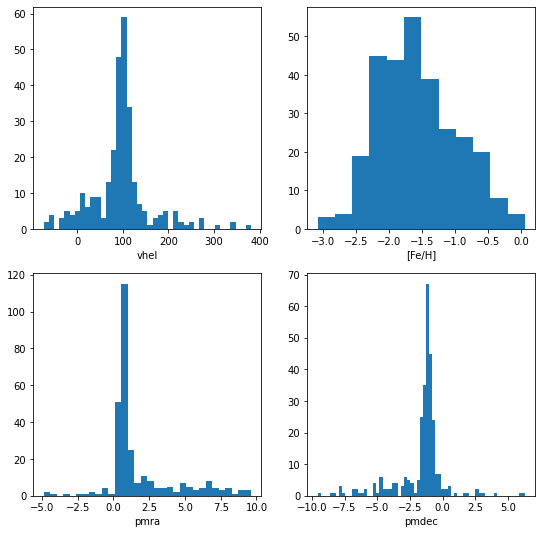

In [6]:
fig, axes = plt.subplots(2,2,figsize=(9,9))
axes[0,0].hist(rv, bins='auto');
axes[0,0].set_xlabel("vhel")
axes[0,1].hist(feh, bins='auto');
axes[0,1].set_xlabel("[Fe/H]")
axes[1,0].hist(pmra, bins='auto');
axes[1,0].set_xlabel("pmra")
axes[1,1].hist(pmdec, bins='auto');
axes[1,1].set_xlabel("pmdec")

# Likelihood function

In [7]:
param_labels = ["pgal","pbg1",
                "vhel","lsigv","feh","lsigfeh",
                "vbg1","lsigvbg1","fehbg1","lsigfeh1",
                "vbg2","lsigvbg2","fehbg2","lsigfeh2",
                "pmra","pmdec","pmra_err","pmdec_err"]
def full_like(theta):
    """ Likelihood and Prior """
    pgal, pbg1, \
    vhel, lsigv, feh0, lsigfeh, \
    vbg1, lsigvbg1, fehbg1, lsigfeh1, \
    vbg2, lsigvbg2, fehbg2, lsigfeh2, \
    pmra_gal, pmdec_gal, pmraerr, pmdecerr = theta
    
    # The prior is just a bunch of hard cutoffs
    if (pgal > 1) or (pgal < 0) or (pbg1 > 1) or (pbg1 < 0) or \
        (lsigv > 3) or (lsigvbg1 > 3) or (lsigvbg2 > 3) or \
        (lsigv < -1) or (lsigvbg1 < -1) or (lsigvbg2 < -1) or \
        (lsigfeh > 1) or (lsigfeh1 > 1) or (lsigfeh1 > 1) or \
        (lsigfeh < -3) or (lsigfeh1 < -3) or (lsigfeh1 < -3) or \
        (vhel > 400) or (vhel < -100) or (vbg1 > 500) or (vbg1 < 50) or \
        (vbg2 > 50) or (vbg2 < -50) or (abs(pmra_gal) > 2) or (abs(pmdec_gal) > 2):
        return -1e10
    
    # Compute log likelihood in rv
    lgal_vhel = stats.norm.logpdf(rv, loc=vhel, scale=np.sqrt(rverr**2 + (10**lsigv)**2))
    lbg1_vhel = stats.norm.logpdf(rv, loc=vbg1, scale=np.sqrt(rverr**2 + (10**lsigvbg1)**2))
    lbg2_vhel = stats.norm.logpdf(rv, loc=vbg2, scale=np.sqrt(rverr**2 + (10**lsigvbg2)**2))
    
    # Compute log likelihood in feh
    lgal_feh = stats.norm.logpdf(feh, loc=feh0, scale=np.sqrt(feherr**2 + (10**lsigfeh)**2))
    lbg1_feh = stats.norm.logpdf(feh, loc=fehbg1, scale=np.sqrt(feherr**2 + (10**lsigfeh1)**2))
    lbg2_feh = stats.norm.logpdf(feh, loc=fehbg2, scale=np.sqrt(feherr**2 + (10**lsigfeh2)**2))
    
    # Compute log likelihood in pmra
    lgal_pmra = stats.norm.logpdf(pmra, loc=pmra_gal, scale=pmraerr)
    
    # Compute log likelihood in pmdec
    lgal_pmdec = stats.norm.logpdf(pmdec, loc=pmdec_gal, scale=pmdecerr)
    
    # background
    lbg1_pm = np.log(pmnorm)
    lbg2_pm = np.log(pmnorm) 
    
    # Combine the components
    lgal = np.log(pgal)+lgal_vhel+lgal_pmra+lgal_pmdec+lgal_feh
    lbg1 = np.log(pbg1)+lbg1_vhel+lbg1_pm+lbg1_feh
    lbg2 = np.log(1-pbg1)+lbg2_vhel+lbg2_pm +lbg2_feh
    lbgtot = np.logaddexp(lbg1, lbg2)
    ltot = np.logaddexp(lgal, np.log(1-pgal)+lbgtot)
    return ltot.sum()

def get_paramdict(theta):
    return OrderedDict(zip(param_labels, theta))

# Optimize parameters



In [8]:
## I found this guess by looking at the plot by eye and estimating. This part requires some futzing.
p0_guess = [0.47, 0.57,
            102, 1.3, -1.9,-0.5,
            140, 2.0, -1.3, -0.37,
            27, 1.6, -0.7, -0.5,
            0.7, -1.1,0.2,0.2]

In [9]:
optfunc = lambda theta: -full_like(theta)

In [10]:
%timeit optfunc(p0_guess)

850 µs ± 1.92 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
optfunc(p0_guess)

2593.2566968859815

In [12]:
%time res = optimize.minimize(optfunc, p0_guess, method="Nelder-Mead")

CPU times: user 3.18 s, sys: 62.8 ms, total: 3.25 s
Wall time: 3.25 s


In [13]:
res.x

array([ 5.87918433e-01,  2.14104035e-01,  1.01778064e+02,  1.31878702e+00,
       -1.87492084e+00, -5.20871453e-01,  2.23662293e+02,  1.87075079e+00,
       -1.61833668e+00, -2.57717425e-01,  4.79534285e+01,  1.77815543e+00,
       -8.96933401e-01, -3.81203363e-01,  7.13210997e-01, -1.14114799e+00,
        2.60324278e-01,  2.76789883e-01])

In [14]:
optfunc(res.x)

2540.9383777122457

In [15]:
for label, p in zip(param_labels, res.x):
    print(f"{label}: {p:.3f}")

pgal: 0.588
pbg1: 0.214
vhel: 101.778
lsigv: 1.319
feh: -1.875
lsigfeh: -0.521
vbg1: 223.662
lsigvbg1: 1.871
fehbg1: -1.618
lsigfeh1: -0.258
vbg2: 47.953
lsigvbg2: 1.778
fehbg2: -0.897
lsigfeh2: -0.381
pmra: 0.713
pmdec: -1.141
pmra_err: 0.260
pmdec_err: 0.277


## Posterior Sampling
The posterior is sampled using `emcee` with 64 walkers and 10,000 steps per chain.

In [17]:
nw = 64
p0 = res['x']
nit = 2000
ep0 = np.zeros(len(p0_guess)) + 0.02
p0s = np.random.multivariate_normal(p0_guess, np.diag(ep0)**2, size=nw)
print(p0s)

[[  0.4775638    0.5846453  101.99710625 ...  -1.14082047   0.19902361
    0.22067917]
 [  0.45826299   0.57716193 102.00360664 ...  -1.10604998   0.20855524
    0.24305695]
 [  0.47899406   0.59156393 102.01674281 ...  -1.09454391   0.23041777
    0.18415315]
 ...
 [  0.47601583   0.56263031 101.99194561 ...  -1.07094277   0.22670668
    0.21203714]
 [  0.47164706   0.58032195 101.99616509 ...  -1.10617397   0.20436021
    0.18174392]
 [  0.47252472   0.57295354 102.03354141 ...  -1.11423925   0.17104168
    0.20537301]]


In [18]:
nparams = len(param_labels)
print(nparams)
nwalkers = 64
p0 = p0_guess
ep0 = np.zeros(len(p0)) + 0.02 # some arbitrary width that's pretty close; scale accordingly to your expectation of the uncertainty
p0s = np.random.multivariate_normal(p0, np.diag(ep0)**2, size=nwalkers)
## Check to see things are initialized ok
lkhds = [full_like(p0s[j]) for j in range(nwalkers)]
assert np.all(np.array(lkhds) > -9e9)

18


In [19]:
def get_rstate():
    return np.random.mtrand.RandomState(seed=np.random.randint(0,2**32-1))
#from schwimmbad import MultiPool
#pool = MultiPool(4)
es = emcee.EnsembleSampler(
    nw, len(p0_guess), full_like)

In [20]:
%time PP = es.run_mcmc(p0s, nit, rstate0=get_rstate())
es.reset()

CPU times: user 1min 41s, sys: 2.03 s, total: 1min 43s
Wall time: 1min 44s


In [21]:
%time es.run_mcmc(PP.coords, nit, rstate0=get_rstate())

CPU times: user 1min 37s, sys: 1.92 s, total: 1min 39s
Wall time: 1min 39s


State([[  0.57784678   0.14979106 102.76594584 ...  -1.16530103   0.26801881
    0.27828786]
 [  0.57361709   0.23029355  99.41093686 ...  -1.10949293   0.27307023
    0.26187781]
 [  0.58348542   0.2202436  105.90001514 ...  -1.08606512   0.274917
    0.2967757 ]
 ...
 [  0.59646079   0.22210808 104.21804523 ...  -1.10435292   0.27702934
    0.28224449]
 [  0.59129265   0.17370809  98.86854972 ...  -1.1452058    0.24937633
    0.28299365]
 [  0.55233457   0.2091804  105.56401495 ...  -1.13687474   0.27382698
    0.27408119]], log_prob=[-2551.20173192 -2549.00105324 -2554.59437469 -2549.86969288
 -2550.88942204 -2547.71990709 -2550.28633775 -2551.2893335
 -2551.93023731 -2546.18476872 -2550.11045641 -2550.80104916
 -2551.74913194 -2548.92249757 -2549.07013427 -2546.5895221
 -2551.27127431 -2555.57563043 -2550.71533904 -2548.41540067
 -2546.37434673 -2549.14524166 -2551.52770599 -2548.38672379
 -2552.86764024 -2546.45396365 -2547.89360495 -2552.09549846
 -2550.34012472 -2556.64293702 -2

In [22]:
outputs = es.flatchain

### Acceptance fraction
Judging the convergence and performance of an algorithm is a non-trival problem. As a rule of thumb, the acceptance fraction should be between 0.2 and 0.5 (for example, Gelman, Roberts, & Gilks 1996).

In [23]:
# Another good test of whether or not the sampling went well is to 
# check the mean acceptance fraction of the ensemble
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(es.acceptance_fraction)
    )
)

Mean acceptance fraction: 0.296


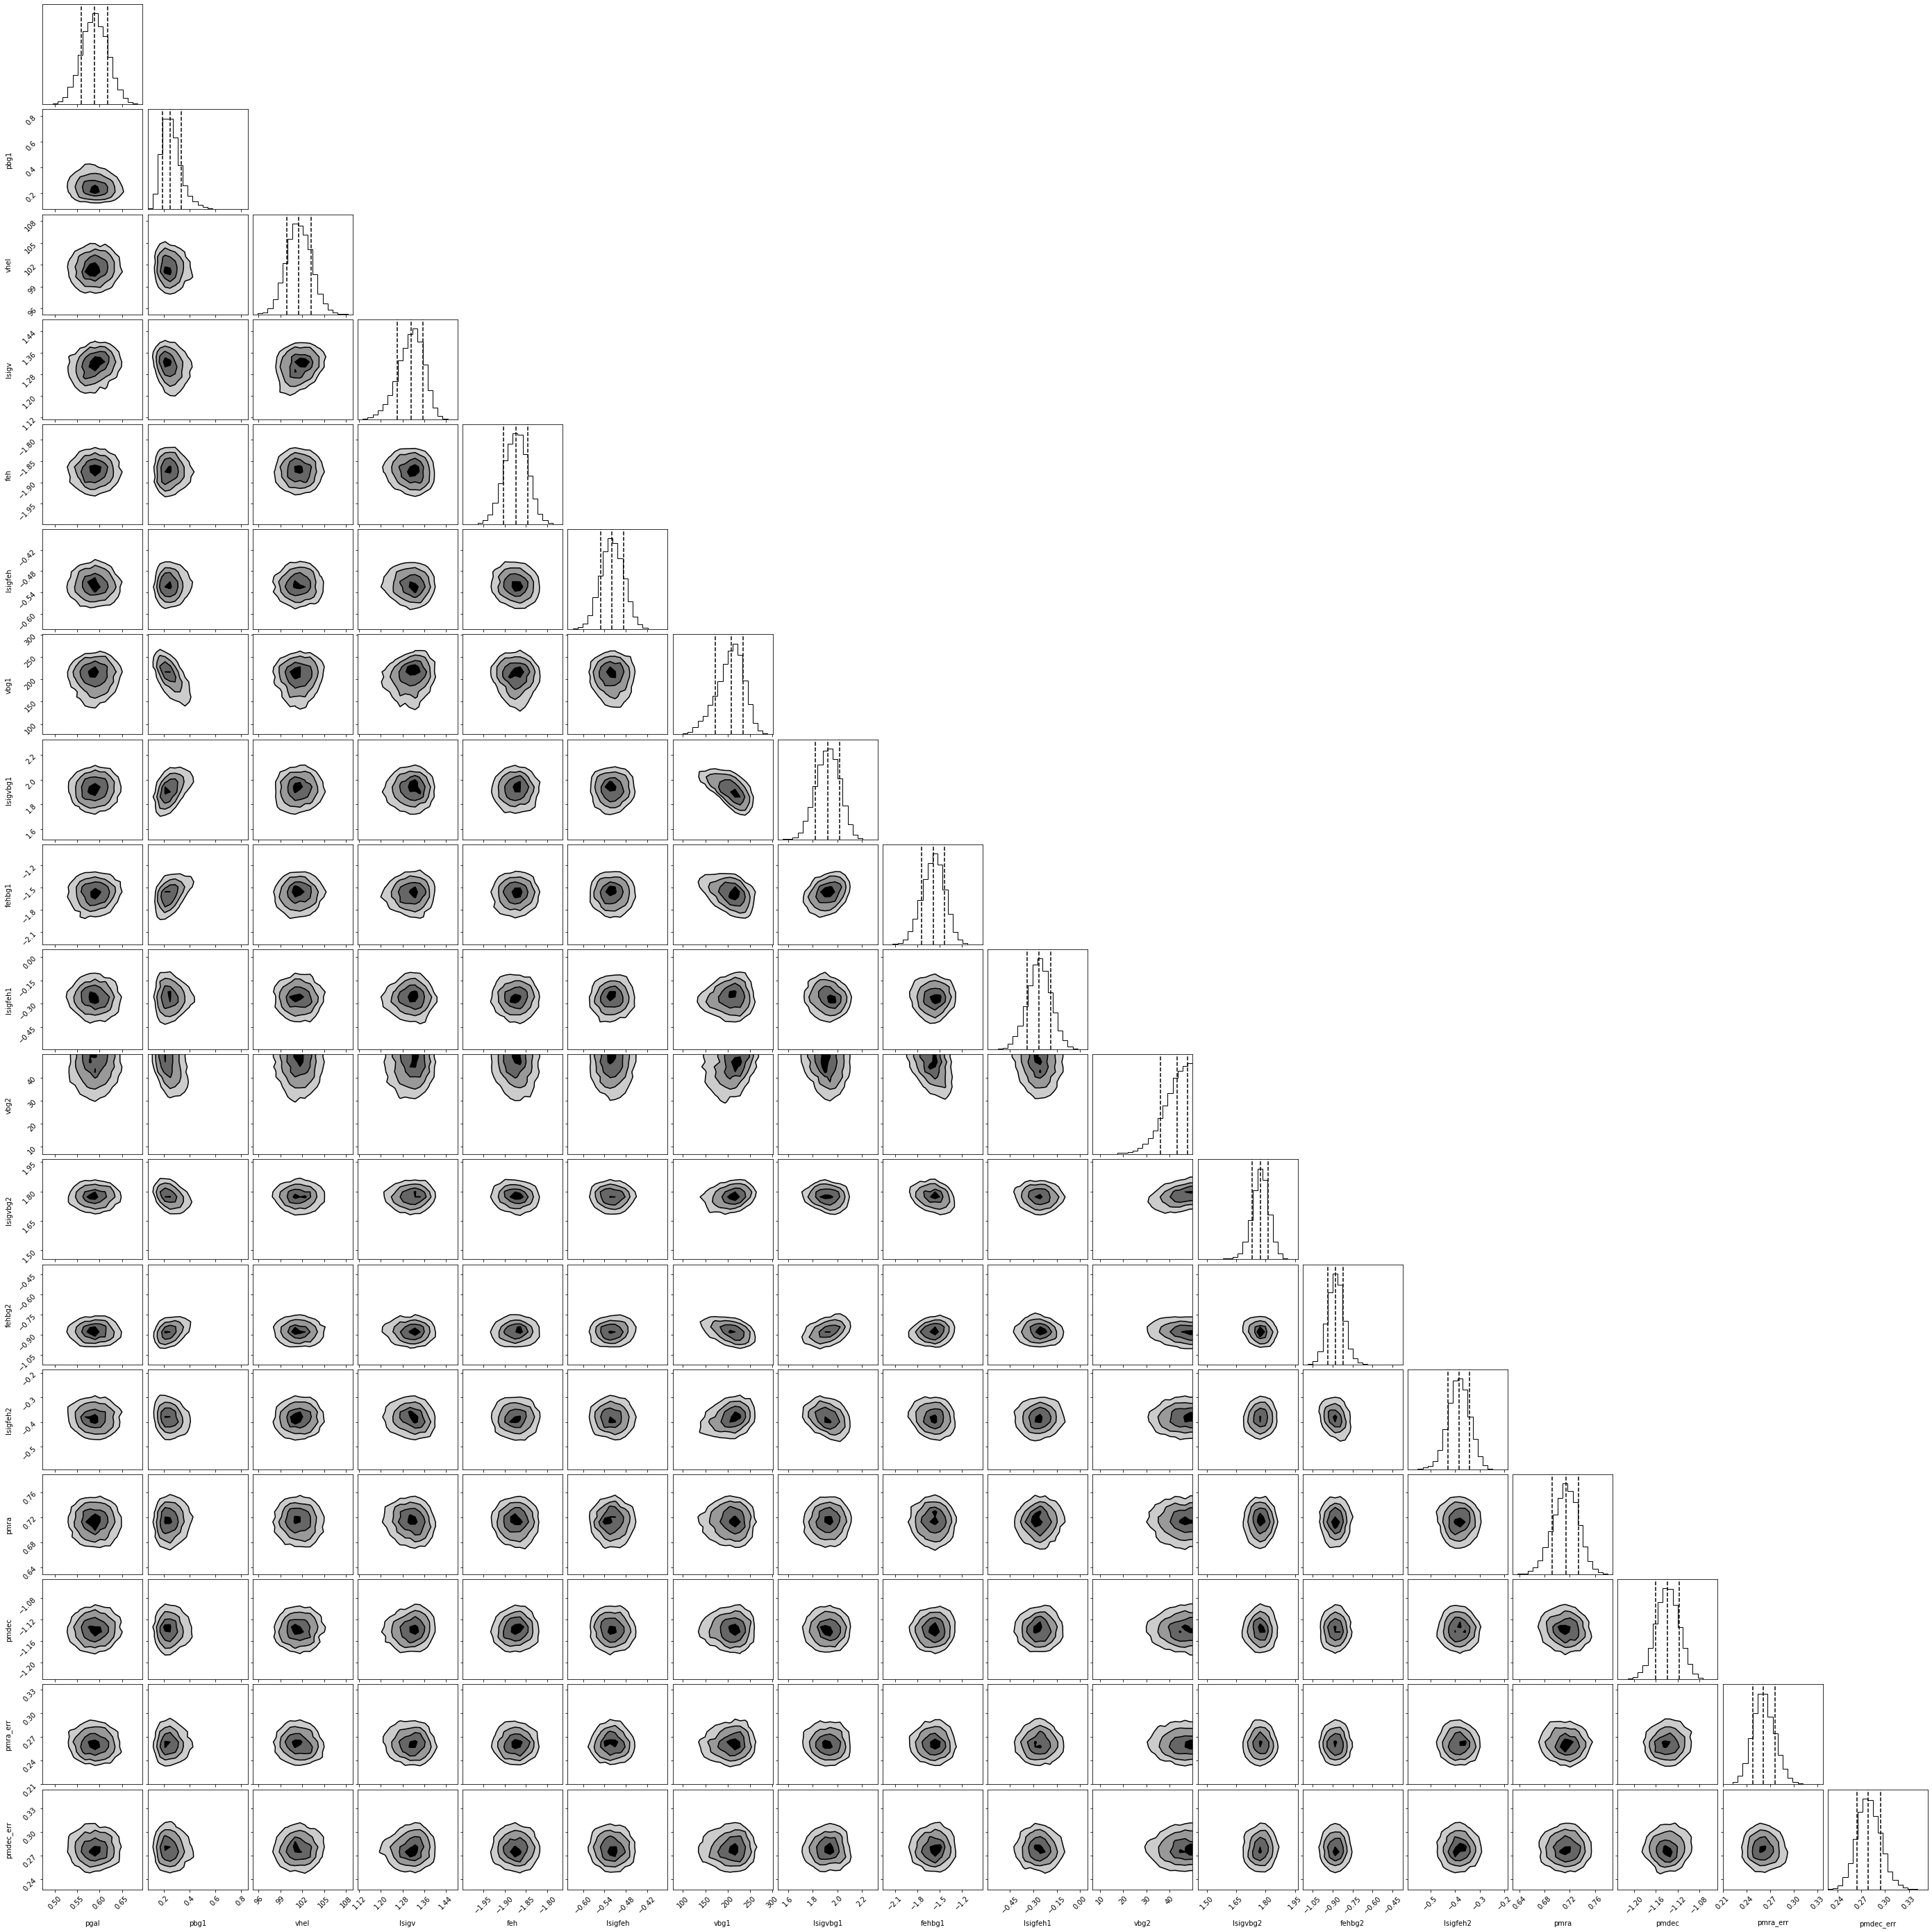

In [24]:
fig = corner.corner(outputs, labels=param_labels, quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})
#plt.savefig('SMCNOD_PM_1DModel_Cornerplot.png')

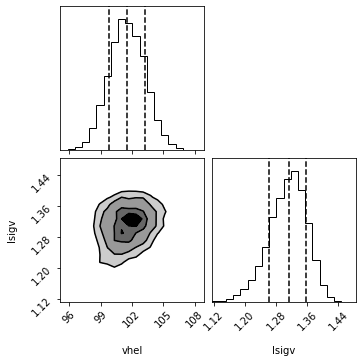

In [25]:
fig1 = corner.corner(outputs[:,2:4], labels=param_labels[2:4], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

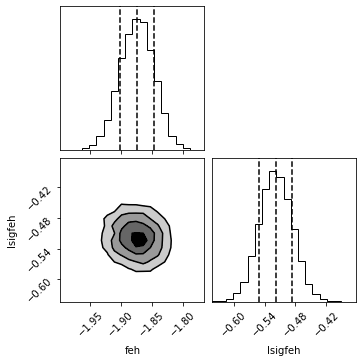

In [26]:
fig2 = corner.corner(outputs[:,4:6], labels=param_labels[4:6], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

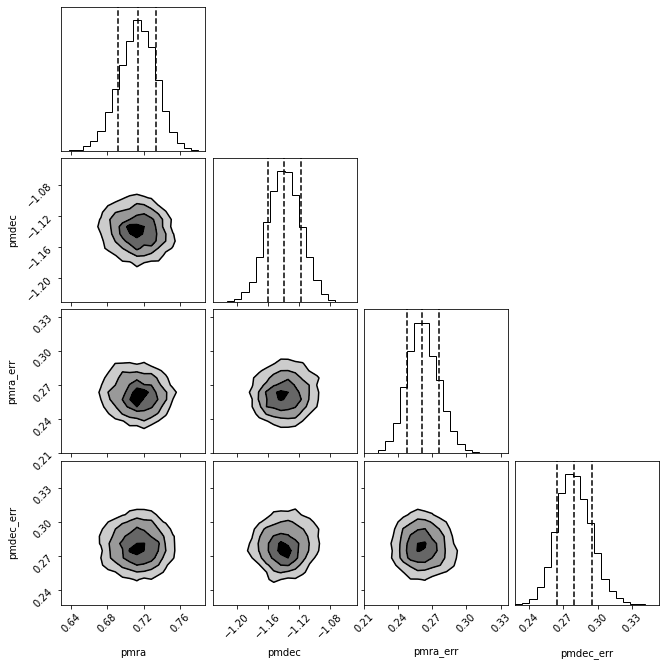

In [27]:
fig3 = corner.corner(outputs[:,14:], labels=param_labels[14:], quantiles=[0.16,0.50,0.84],color='black', # add some colors
              **{'plot_datapoints': False, 'fill_contours': True})

In [28]:
def process_chain(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    meds = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error: # just for simplicity, assuming no asymmetry
        err = (ep-em)/2
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, err))
    else:
        return OrderedDict(zip(param_labels, meds)), OrderedDict(zip(param_labels, ep)), OrderedDict(zip(param_labels, em))

In [29]:
meds, errs = process_chain(outputs)

In [30]:
for k,v in meds.items():
    print("{} {:.3f} {:.3f}".format(k, v, errs[k]))

pgal 0.589 0.029
pbg1 0.250 0.073
vhel 101.509 1.714
lsigv 1.313 0.047
feh -1.873 0.028
lsigfeh -0.519 0.032
vbg1 208.105 30.643
lsigvbg1 1.924 0.097
fehbg1 -1.580 0.153
lsigfeh1 -0.262 0.076
vbg2 43.188 5.877
lsigvbg2 1.775 0.042
fehbg2 -0.876 0.059
lsigfeh2 -0.385 0.043
pmra 0.714 0.021
pmdec -1.139 0.022
pmra_err 0.261 0.014
pmdec_err 0.279 0.015


If things are well mixed, then you can just use the flat chain to concatenate all the walkers and steps.
The results here may not be perfectly mixed, but it's not terrible.
There are fancy ways to check things here involving autocorrelation times that Alex does not know about.
To me this is the hard part of emcee: knowing when you're happy with the result, and setting things up so that it gets there as fast as possible. This is why I prefer dynesty, even though it's slower it has a motivated stopping condition.

In [32]:
chain = es.flatchain
chain.shape

(128000, 18)

You can see the output of the fit as a corner plot. Basically you want everything to be nice and round, and if not that means you didn't initialize your walkers well enough or burn in for long enough.

It's customary to summarize the data with percentiles, but you should check the corner plot diagonal to see if this is a good idea.

In [38]:
chain_new = np.exp(chain)
mean_vdisp = np.percentile(chain_new[:,3], 50)
std_vdisp = (np.percentile(chain_new[:,3], 84)-np.percentile(chain_new[:,3], 16))/2
mean_fehdisp = np.percentile(chain_new[:,5], 50)
std_fehdisp = (np.percentile(chain_new[:,5], 84)-np.percentile(chain_new[:,7], 16))/2
print("mean_vdisp: ",mean_vdisp, \
     "std_vdisp: ",std_vdisp)
print("mean_fehdisp: ",mean_fehdisp, \
     "std_fehdisp: ",std_fehdisp)

mean_vdisp:  3.717430613882213 std_vdisp:  0.1759076887136164
mean_fehdisp:  0.5952965173324546 std_fehdisp:  -2.7906705287014213


In [36]:
param_labels_1 = ["pgal = ","pbg1 = ",
                "vhel = ","lsigv = ","feh = ","lsigfeh = ",
                "vbg1 = ","lsigvbg1 = ","fehbg1 = ","lsigfeh1 = ",
                "vbg2 = ","lsigvbg2 = ","fehbg2 = ","lsigfeh2 = ",
                "pmra = ","pmdec = ","pmraerr = ","pmdecerr="]
def process_chain_1(chain, avg_error=True):
    pctl = np.percentile(chain, [16, 50, 84], axis=0)
    median = pctl[1]
    ep = pctl[2]-pctl[1]
    em = pctl[0]-pctl[1]
    if avg_error:
        err = (ep-em)/2
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, err))
    else:
        return OrderedDict(zip(param_labels_1, median)), OrderedDict(zip(param_labels_1, ep)), OrderedDict(zip(param_labels_1, em))

meds_1, errs_1 = process_chain_1(outputs)

for k,v in meds_1.items():
    print("{} {:.3f}".format(k, v))

pgal =  0.589
pbg1 =  0.250
vhel =  101.509
lsigv =  1.313
feh =  -1.873
lsigfeh =  -0.519
vbg1 =  208.105
lsigvbg1 =  1.924
fehbg1 =  -1.580
lsigfeh1 =  -0.262
vbg2 =  43.188
lsigvbg2 =  1.775
fehbg2 =  -0.876
lsigfeh2 =  -0.385
pmra =  0.714
pmdec =  -1.139
pmraerr =  0.261
pmdecerr= 0.279
